# Classification of Asteroids in the 4J-2S-1 Mean-Motion Resonance Using Machine Learning

## Introduction

This project aims to develop an automated classifier to identify whether an asteroid is trapped in the **4J-2S-1 mean-motion resonance**, a three-body resonance involving **Jupiter and Saturn**. The goal is to provide a predictive tool that, using the asteroid's proper orbital elements (from the AstDyS catalog), can determine the likelihood of resonance without requiring costly numerical simulations.

Planetary resonances play a key role in the long-term dynamical evolution and stability of asteroids in the Solar System. However, detecting resonance membership through dynamical analysis is computationally intensive. This project proposes a machine learning approach as a fast and scalable alternative.

---

## Data Sources

- **AstDyS Catalog (`all.syn`)**: Provides proper elements for asteroids such as proper semi-major axis (`a_p`), proper eccentricity (`e_p`), and the sine of the proper inclination (`sin(i_p)`), along with asteroid identification numbers.
- **Resonant Asteroid List (`4J-2S-1_up_200000.csv`)**: Contains the identifiers of asteroids previously found to be trapped in the 4J-2S-1 resonance.

By combining these datasets, we construct a labeled dataset with binary classification: `resonant` and `non-resonant`.

---

## Methodology

1. **Data Preprocessing**: Extract and clean the data, merge the two lists, and assign binary labels.
2. **Model Training** using several supervised learning algorithms, including:
   - k-Nearest Neighbors (kNN)
   - Decision Tree
   - Random Forest
   - Gradient Boosting
3. **Performance Evaluation** using metrics such as:
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - Cross-validation
4. **Model Selection** based on the highest F1-score and consistent performance across cross-validation folds.

---

## Final Goal

To build a classifier that can take the number of an asteroid listed in the AstDyS catalog and predict whether it is part of the 4J-2S-1 mean-motion resonance. This classifier can be used to assist researchers in rapidly identifying candidate resonant asteroids without full dynamical analysis.


## Import libraries

In [17]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## 1. Load data 


In [6]:
# Carrega lista de elementos próprios no formato AstDyS
with open('/home/manoel/Documents/Deep_learning/MML/all.syn', 'r') as f:
    lines = f.readlines()


In [8]:
# Pula cabeçalho e extrai colunas importantes (número, a_p, e_p, sin(i_p))
columns = ['number', 'a_p', 'e_p', 'sin_i_p']
data = []

for line in lines:
    parts = line.strip().split()
    try:
        number = int(parts[0])
        a_p = float(parts[2])
        e_p = float(parts[3])
        sin_i_p = float(parts[4])
        data.append([number, a_p, e_p, sin_i_p])
    except (ValueError, IndexError):
        continue  # Ignora linhas mal formatadas ou com dados não numéricos

df_elements = pd.DataFrame(data, columns=columns)


In [10]:

# Carrega a lista de asteroides ressonantes (apenas os números)
df_resonant = pd.read_csv('/home/manoel/Documents/Deep_learning/MML/4J-2S-1_up_200000.csv', header=None, names=['number'])

## 2. Label creation (resonant / non-resonant)


In [11]:
df_elements['resonant'] = df_elements['number'].isin(df_resonant['number']).astype(int)


## 3. Train model and avaliation 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === 7. Define e avalia múltiplos classificadores ===
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['non-resonant', 'resonant']))
    
    results.append((name, acc, f1))


=== Random Forest ===
              precision    recall  f1-score   support

non-resonant       1.00      1.00      1.00     92850
    resonant       0.49      0.33      0.39       100

    accuracy                           1.00     92950
   macro avg       0.74      0.66      0.70     92950
weighted avg       1.00      1.00      1.00     92950


=== Decision Tree ===
              precision    recall  f1-score   support

non-resonant       1.00      1.00      1.00     92850
    resonant       0.40      0.41      0.40       100

    accuracy                           1.00     92950
   macro avg       0.70      0.70      0.70     92950
weighted avg       1.00      1.00      1.00     92950


=== KNN ===
              precision    recall  f1-score   support

non-resonant       1.00      1.00      1.00     92850
    resonant       0.42      0.15      0.22       100

    accuracy                           1.00     92950
   macro avg       0.71      0.57      0.61     92950
weighted avg   

/home/manoel/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manoel/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/manoel/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Model comparison table


In [21]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-score'])
results_df = results_df.sort_values(by='F1-score', ascending=False)
print("\n=== Comparação de Modelos ===")
print(results_df)


=== Comparação de Modelos ===
                 Model  Accuracy  F1-score
3    Gradient Boosting  0.998494  0.570552
1        Decision Tree  0.998698  0.403941
0        Random Forest  0.998903  0.392857
2                  KNN  0.998860  0.220588
4  Logistic Regression  0.998924  0.000000


##  5. Asteroid classification


In [26]:
# Número do asteroide a ser testado
asteroid_number = 56731  # Substitua por qualquer número

# Busca os dados orbitais
asteroid_data = df_elements[df_elements['number'] == asteroid_number]

if not asteroid_data.empty:
    features = asteroid_data[['a_p', 'e_p', 'sin_i_p']]
    prediction = model.predict(features)[0]
    label = 'resonant' if prediction == 1 else 'non-resonant'
    print(f'Asteroide {asteroid_number} é classificado como: {label}')
else:
    print(f'Asteroide {asteroid_number} não encontrado no catálogo.')

Asteroide 56731 é classificado como: non-resonant


## 6. Better model

In [22]:
best_model_name = results_df.iloc[0]['Model']
print(f"\n🎯 Melhor modelo: {best_model_name}")



🎯 Melhor modelo: Gradient Boosting


## 7. Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# === Validação cruzada 5-fold ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    print(f"\n=== {name} ===")
    print(f"F1-score (média ± std): {f1.mean():.4f} ± {f1.std():.4f}")
    print(f"Accuracy (média ± std): {acc.mean():.4f} ± {acc.std():.4f}")
    
    results.append((name, acc.mean(), f1.mean()))

# === Tabela final comparativa ===
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-score'])
results_df = results_df.sort_values(by='F1-score', ascending=False)

print("\n=== Comparação de Modelos com Validação Cruzada ===")
print(results_df)



=== Random Forest ===
F1-score (média ± std): 0.3994 ± 0.0430
Accuracy (média ± std): 0.9989 ± 0.0001

=== Decision Tree ===
F1-score (média ± std): 0.4350 ± 0.0265
Accuracy (média ± std): 0.9988 ± 0.0001

=== KNN ===
F1-score (média ± std): 0.2068 ± 0.0480
Accuracy (média ± std): 0.9989 ± 0.0000

=== Gradient Boosting ===
F1-score (média ± std): 0.0114 ± 0.0093
Accuracy (média ± std): 0.9989 ± 0.0000

=== Logistic Regression ===
F1-score (média ± std): 0.0000 ± 0.0000
Accuracy (média ± std): 0.9989 ± 0.0000

=== Comparação de Modelos com Validação Cruzada ===
                 Model  Accuracy  F1-score
1        Decision Tree  0.998780  0.435032
0        Random Forest  0.998931  0.399441
2                  KNN  0.998892  0.206779
3    Gradient Boosting  0.998900  0.011415
4  Logistic Regression  0.998924  0.000000


## Confusion Matrix from cross-validation


🎯 Melhor modelo: Decision Tree



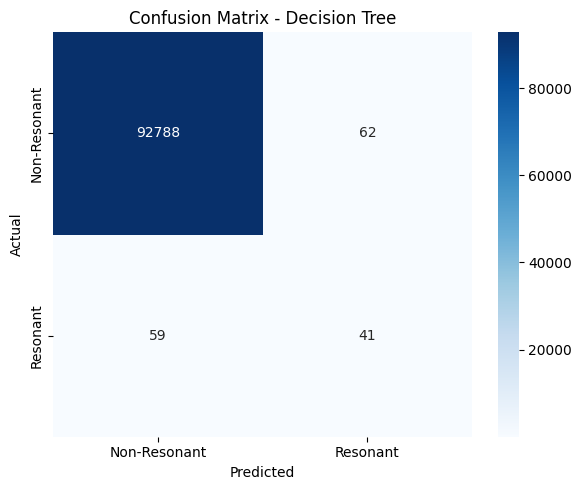

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Escolhe o melhor modelo com base no F1-score médio ===
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n🎯 Melhor modelo: {best_model_name}\n")

# === Treina o melhor modelo com o conjunto de treino ===
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# === Gera a matriz de confusão ===
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Resonant', 'Resonant']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()
